<a href="https://colab.research.google.com/github/MasterVishvesh/Inventory-Management_LSTMModel/blob/main/Inventory_Management_LSTMModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

In [ ]:
# !pip install google-auth
# from google.colab import drive
# from google.auth import default

# # Authenticate and create the Drive FUSE wrapper.
# # This will ask for an authorization code.
# from google.colab import auth
# auth.authenticate_user()

# from google.colab import drive
# drive.mount('/content/drive')


from google.colab import files
uploaded = files.upload()


Saving sales_prediction_numeric.csv to sales_prediction_numeric (1).csv


In [ ]:
df = pd.read_csv('sales_prediction_numeric.csv')
df.head(10)

,date,store_id,item_id,sales
0,01-01-2020,1,1,23
1,01-01-2020,1,2,12
2,01-01-2020,1,3,25
3,01-01-2020,1,4,39
4,01-01-2020,1,5,18
5,01-01-2020,1,6,20
6,01-01-2020,1,7,26
7,01-01-2020,1,8,13
8,01-01-2020,1,9,21
9,01-01-2020,1,10,20


In [ ]:
df.shape
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548500 entries, 0 to 548499
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   date      548500 non-null  object
 1   store_id  548500 non-null  int64 
 2   item_id   548500 non-null  int64 
 3   sales     548500 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 16.7+ MB


In [ ]:
list  = df.isnull().sum()
print(list)
df.shape

date        0
store_id    0
item_id     0
sales       0
dtype: int64


(548500, 4)

In [ ]:
df1 = df.dropna()
df1.shape
list = df1.isnull().sum()
print(list)

date        0
store_id    0
item_id     0
sales       0
dtype: int64


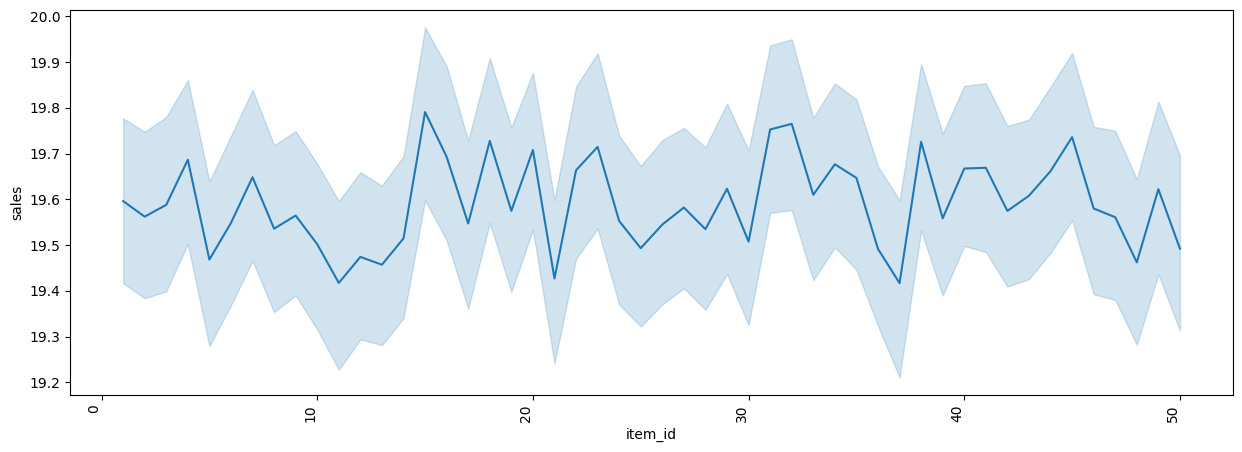

In [ ]:
plt.figure(figsize=(15, 5))
sns.lineplot(y='sales', x='item_id', data=df1)

plt.xticks(rotation=90, ha='right')

plt.show()

In [ ]:
# Creating lag features
df["lag_1"] = df.groupby(["item_id", "date"])["sales"].shift(1)
df["lag_2"] = df.groupby(["item_id", "date"])["sales"].shift(2)
df["lag_3"] = df.groupby(["item_id", "date"])["sales"].shift(3)


# Rolling averages
df["rolling_mean_3"] = df.groupby("item_id")["sales"].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df["rolling_mean_6"] = df.groupby("item_id")["sales"].transform(lambda x: x.rolling(window=6, min_periods=1).mean())
# df.head()
# df.tail()


In [ ]:
df.fillna(0, inplace=True)


# Define features and target
features = [ "sales", "lag_1", "rolling_mean_3", "rolling_mean_6", "item_id"]
X = df[features]
y = df["sales"]

# Convert 'item_id' to numerical using Label Encoding
le = LabelEncoder()
#Spli into test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


# spliting the training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=False)


scaler = MinMaxScaler()
scaler.fit(y_train.values.reshape(-1, 1))


# Reshape input for LSTM
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)  # Reshape to [samples, timesteps, features]
X_val = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1) # Reshape validation data as well
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1) # Reshape validation data as well


In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.01))))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

optimizer= Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')


early_stopping = EarlyStopping(monitor='val_loss', patience=5) # Stop if validation loss doesn't improve for 10 epochs
model.fit(X_train, y_train, batch_size=64, epochs=15, callbacks=[early_stopping], validation_data=(X_val, y_val))


Epoch 1/15
5485/5485 ━━━━━━━━━━━━━━━━━━━━ 70s 12ms/step - loss: 29.6238 - val_loss: 0.5494
Epoch 2/15
5485/5485 ━━━━━━━━━━━━━━━━━━━━ 69s 13ms/step - loss: 1.2062 - val_loss: 0.0618
Epoch 3/15
5485/5485 ━━━━━━━━━━━━━━━━━━━━ 64s 12ms/step - loss: 0.9665 - val_loss: 0.0907
Epoch 4/15
5485/5485 ━━━━━━━━━━━━━━━━━━━━ 67s 12ms/step - loss: 0.9452 - val_loss: 0.1307
Epoch 5/15
5485/5485 ━━━━━━━━━━━━━━━━━━━━ 63s 12ms/step - loss: 0.9062 - val_loss: 0.0897
Epoch 6/15
5485/5485 ━━━━━━━━━━━━━━━━━━━━ 68s 12ms/step - loss: 0.9102 - val_loss: 0.0483
Epoch 7/15
5485/5485 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - loss: 0.8951 - val_loss: 0.0378
Epoch 8/15
5485/5485 ━━━━━━━━━━━━━━━━━━━━ 83s 12ms/step - loss: 0.8798 - val_loss: 0.0805
Epoch 9/15
5485/5485 ━━━━━━━━━━━━━━━━━━━━ 77s 11ms/step - loss: 0.8617 - val_loss: 0.2862
Epoch 10/15
5485/5485 ━━━━━━━━━━━━━━━━━━━━ 86s 12ms/step - loss: 0.8619 - val_loss: 0.0578
Epoch 11/15
5485/5485 ━━━━━━━━━━━━━━━━━━━━ 62s 11ms/step - loss: 0.8594 - val_loss: 0.0728
Epoch 1

In [54]:
# Fit the model
early_stopping = EarlyStopping(monitor='loss', patience=3)
model.fit(X_train, y_train, batch_size=64, epochs=5, callbacks=[early_stopping])

Epoch 1/5
5485/5485 ━━━━━━━━━━━━━━━━━━━━ 58s 10ms/step - loss: 0.8136
Epoch 2/5
5485/5485 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - loss: 0.8087
Epoch 3/5
5485/5485 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 0.8048
Epoch 4/5
5485/5485 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - loss: 0.8096
Epoch 5/5
5485/5485 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - loss: 0.8098


In [55]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (64, 5, 128)           │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (64, 5, 128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (64, 32)               │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (64, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (64, 25)               │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (64, 1)                │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 165,755 (647.48 KB)

 Trainable params: 55,251 (215.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 110,504 (431.66 KB)

In [56]:
predictions= model.predict(X_train)
predictions

10970/10970 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step


array([[23.180199 ],
       [12.0415535],
       [25.180206 ],
       ...,
       [15.066706 ],
       [16.077908 ],
       [29.1859   ]], dtype=float32)

In [57]:
inv_predictions = scaler.inverse_transform(predictions)
inv_predictions

array([[1576.2535],
       [ 818.8256],
       [1712.254 ],
       ...,
       [1024.536 ],
       [1093.2977],
       [1984.6412]], dtype=float32)

In [58]:
# inv_y_test = scaler.inverse_transform(y_test)
inv_y_test = scaler.inverse_transform(y_test.values.reshape(-1, 1))  # Reshape y_test to a 2D array
inv_y_test

array([[2516.],
       [1360.],
       [2108.],
       ...,
       [1768.],
       [1496.],
       [ 476.]])

In [59]:
# rmse = np.sqrt(mean_squared_error((inv_predictions - inv_y_test)**2))
# rmse

# Predict on the test set instead of the training set
# predictions = model.predict(X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1))  # Reshape X_test for LSTM
predictions=model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1)) # Reshape X_test for LSTM, removing .values

# Inverse transform the predictions
inv_predictions = scaler.inverse_transform(predictions)


# Calculate RMSE using the predictions and actual values from the test set
rmse = np.sqrt(mean_squared_error(inv_y_test, inv_predictions))

print(rmse)

3429/3429 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
10.085078883094662


In [60]:
ploting_data = pd.DataFrame({'Actual': inv_y_test.flatten(), 'Predicted': inv_predictions.flatten()})
ploting_data

,Actual,Predicted
0,2516.0,2489.974609
1,1360.0,1363.476562
2,2108.0,2105.455322
3,204.0,186.284790
4,1088.0,1090.451538
...,...,...
109695,1632.0,1644.060303
109696,1768.0,1783.063599
109697,1768.0,1782.893677
109698,1496.0,1500.304321


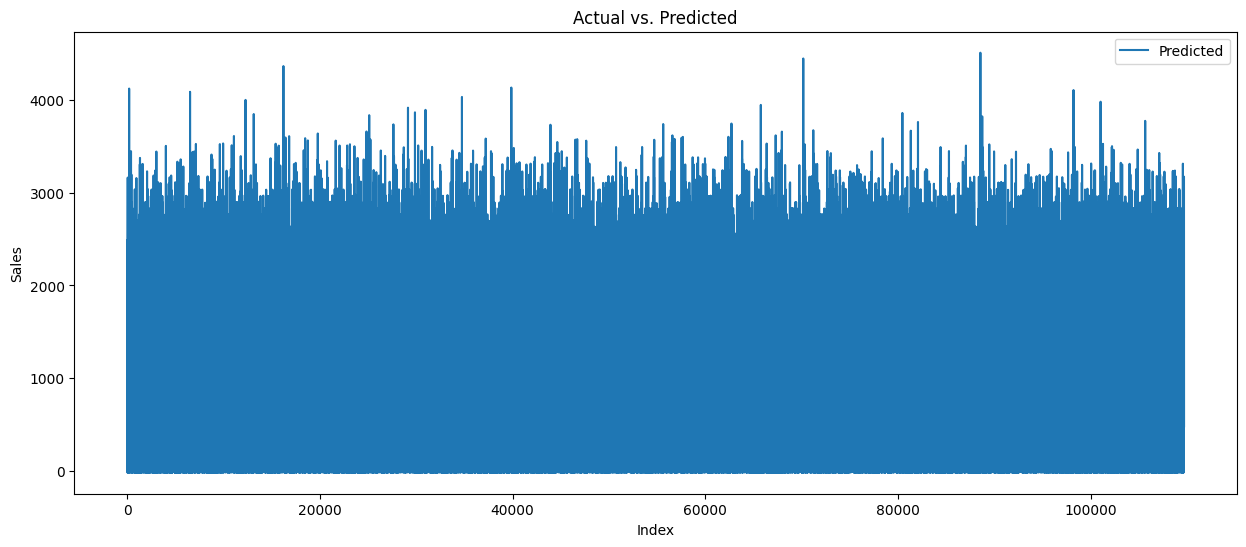

In [61]:
plt.figure(figsize=(15,6))
# plt.plot(ploting_data['Actual'], label='Actual')  # Using 'ploting_data' instead of 'data'
plt.plot(ploting_data['Predicted'], label='Predicted')  # Using 'ploting_data' instead of 'data'
plt.legend()
plt.title('Actual vs. Predicted')
plt.xlabel('Index')  # You might want to adjust the x-axis label
plt.ylabel('Sales')  # Use the actual column name for the y-axis label
plt.show()

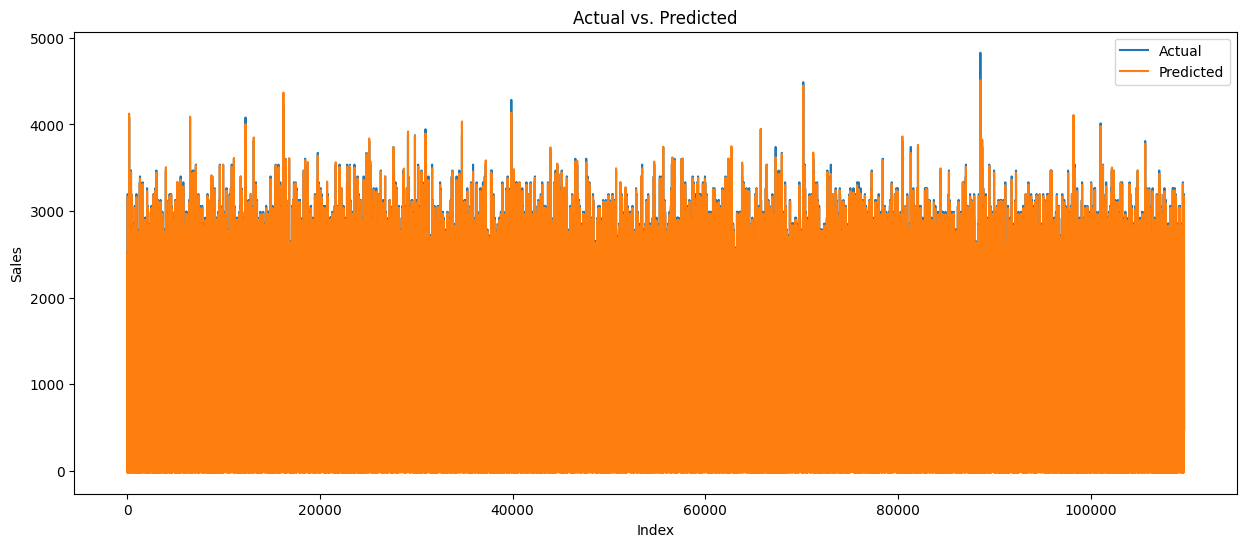

In [62]:
plt.figure(figsize=(15,6))
plt.plot(ploting_data['Actual'], label='Actual')  # Using 'ploting_data' instead of 'data'
plt.plot(ploting_data['Predicted'], label='Predicted')  # Using 'ploting_data' instead of 'data'
plt.legend()
plt.title('Actual vs. Predicted')
plt.xlabel('Index')  # You might want to adjust the x-axis label
plt.ylabel('Sales')  # Use the actual column name for the y-axis label
plt.show()